# Susceptibility Artifact Dataset
This project simulates a susceptibility artifact, and generates a CNN training dataset for the artifact.
Author: Martin Reinok (University of Twente)

## MRI Static settings for simulation

In [1]:
class FOV(object):
    def __init__(self, X, Y):
        self.x = X
        self.y = Y
        
B0 = 1.5  # Tesla
SLICE_THICKNESS = 10  # mm
SIMULATION_RESOLUTION = 300  # distribution of calculation points over chosen pixel resolution, capped at ~600 due to 24GB VRAM.
GYROMAGNETIC_RATIO = 42576384.7  # in Hz/T
P_XYZ = 1  # Assuming uniform signal producing spin density, p(x,y,z) can be taken as 1

## MRI variable settings for simulation
These may be changed for data augmentation

In [2]:
FOV = FOV(20, 20)
voxel_size = 1.2  # mm
echo_time_ms = 4.45  # ms
"""
Dynamic variables
Don't change these
"""
TE = echo_time_ms * 0.001  # seconds
delta_x_V = voxel_size * 0.01

## Use GPU for numpy calculations
cupy is used to distribute simulation to Nvidia GPU.

In [3]:
import cupy as cp
import numpy as np

if cp.cuda.runtime.getDeviceCount() > 1:
    if cp.cuda.Device(0).compute_capability > cp.cuda.Device(1).compute_capability:
        cp.cuda.Device(0).use()
    else:
        cp.cuda.Device(1).use()
else:
    cp.cuda.Device(0).use()

## Initialize simulation spatial range

In [4]:
x = cp.linspace(-FOV.x, FOV.y, SIMULATION_RESOLUTION)
y = cp.linspace(-FOV.x, FOV.y, SIMULATION_RESOLUTION)
z = cp.linspace(-FOV.x, FOV.y, SIMULATION_RESOLUTION)
X, Y, Z = cp.meshgrid(x, y, z)

## Simulation

In [5]:
import matplotlib.pyplot as plt
import helper_methods as helper

def quick_plot(data, cmap, size=None, title=None, colorbar=True, axis=True):
    if size:
        plt.figure(figsize=(size, size))
    plt.imshow(data, cmap=cmap)
    if title is not None:
        plt.title(title)
    plt.tight_layout()
    if not axis:
        plt.axis('off')
    if colorbar:
        plt.colorbar()
    plt.show()

### Dipole field
Based on paper:
**Passive tracking exploiting local signal conservation: the white marker phenomenon**
PMID: 14523965

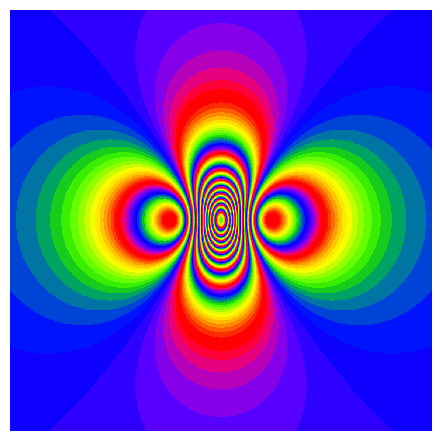

In [6]:
c = B0 * delta_x_V / (4 * cp.pi)
Bz = c * (X ** 2 + Y ** 2 - 2 * Z ** 2) / ((X ** 2 + Y ** 2 + Z ** 2) ** (5 / 2))
quick_plot(helper.normalize(cp.ndarray.get(Bz)[:, 120, :]), cmap='prism', axis=False, colorbar=False)

### Integration over slice direction

In [7]:
S_axial = 1 / SLICE_THICKNESS * cp.trapz(P_XYZ * cp.exp(-1j * GYROMAGNETIC_RATIO * Bz * TE), Z, axis=2)
S_coronal = 1 / SLICE_THICKNESS * cp.trapz(P_XYZ * cp.exp(-1j * GYROMAGNETIC_RATIO * Bz * TE), Y, axis=0)

### Data post-processing
- Cupy is converted to numpy
- np.angle and np.abs are used to separate phase and magnitude
- Data is normalized to 0-1 range
- Data is rotated by 90 degrees

In [8]:
coronal_phase = np.rot90(helper.normalize(np.angle(cp.asnumpy(S_coronal))))
coronal_magnitude = np.rot90(helper.normalize(np.abs(cp.asnumpy(S_coronal))))
axial_phase = np.rot90(helper.normalize(np.angle(cp.asnumpy(S_axial))))
axial_magnitude = np.rot90(helper.normalize(np.abs(cp.asnumpy(S_axial))))

#### Visualization

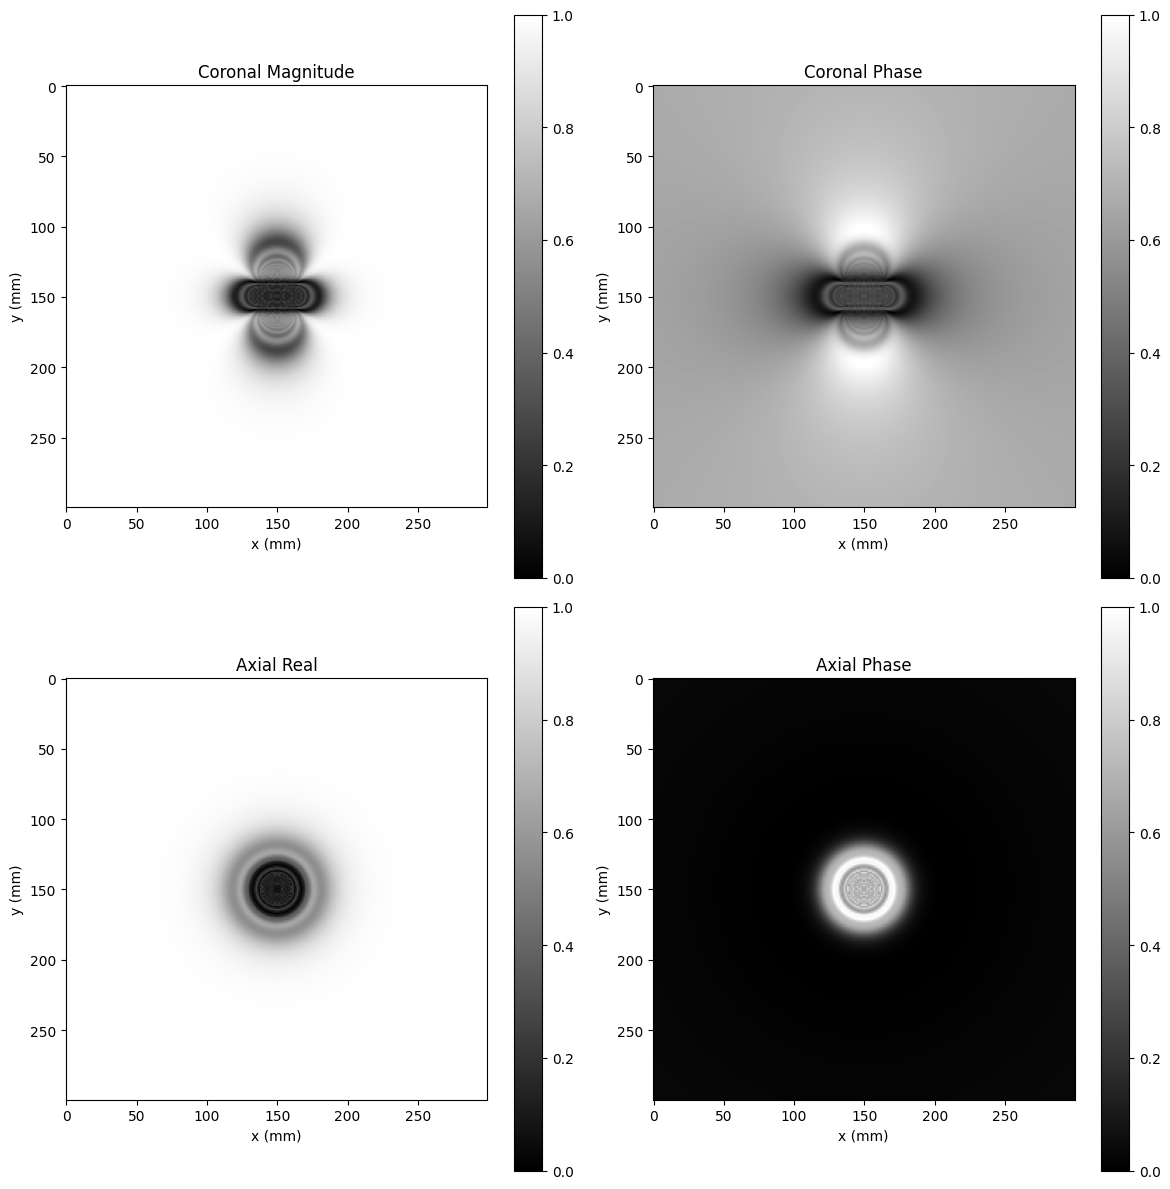

In [9]:
def group_plot(coronal_magnitude, coronal_phase, axial_magnitude, axial_phase,
               title1="Coronal Magnitude", title2="Coronal Phase", title3="Axial Real", title4="Axial Phase", cmap="gray", clim=None):
    plt.figure(figsize=(12, 12))
    
    plt.subplot(2, 2, 1)
    plt.imshow(coronal_magnitude, cmap="gray")
    plt.title(title1)
    plt.xlabel("x (mm)")
    plt.ylabel("y (mm)")
    if clim is not None:
        plt.clim(clim)
    plt.colorbar()
    
    if coronal_phase is not None:
        plt.subplot(2, 2, 2)
        plt.imshow(coronal_phase, cmap="gray")
        plt.title(title2)
        plt.xlabel("x (mm)")
        plt.ylabel("y (mm)")
        if clim is not None:
            plt.clim(clim)
        plt.colorbar()
    
    if axial_magnitude is not None:
        plt.subplot(2, 2, 3)
        plt.imshow(axial_magnitude, cmap="gray")
        plt.title(title3)
        plt.xlabel("x (mm)")
        plt.ylabel("y (mm)")
        if clim is not None:
            plt.clim(clim)
        plt.colorbar()
        
    if axial_phase is not None:
        plt.subplot(2, 2, 4)
        plt.imshow(axial_phase, cmap="gray")
        plt.title(title4)
        plt.xlabel("x (mm)")
        plt.ylabel("y (mm)")
        if clim is not None:
            plt.clim(clim)
        plt.colorbar()
    
    plt.tight_layout()
    plt.show()
group_plot(coronal_magnitude, coronal_phase, axial_magnitude, axial_phase)

### Adding a color LUT to match MRI bSSFP colors
N enforces that the data is 16bit.

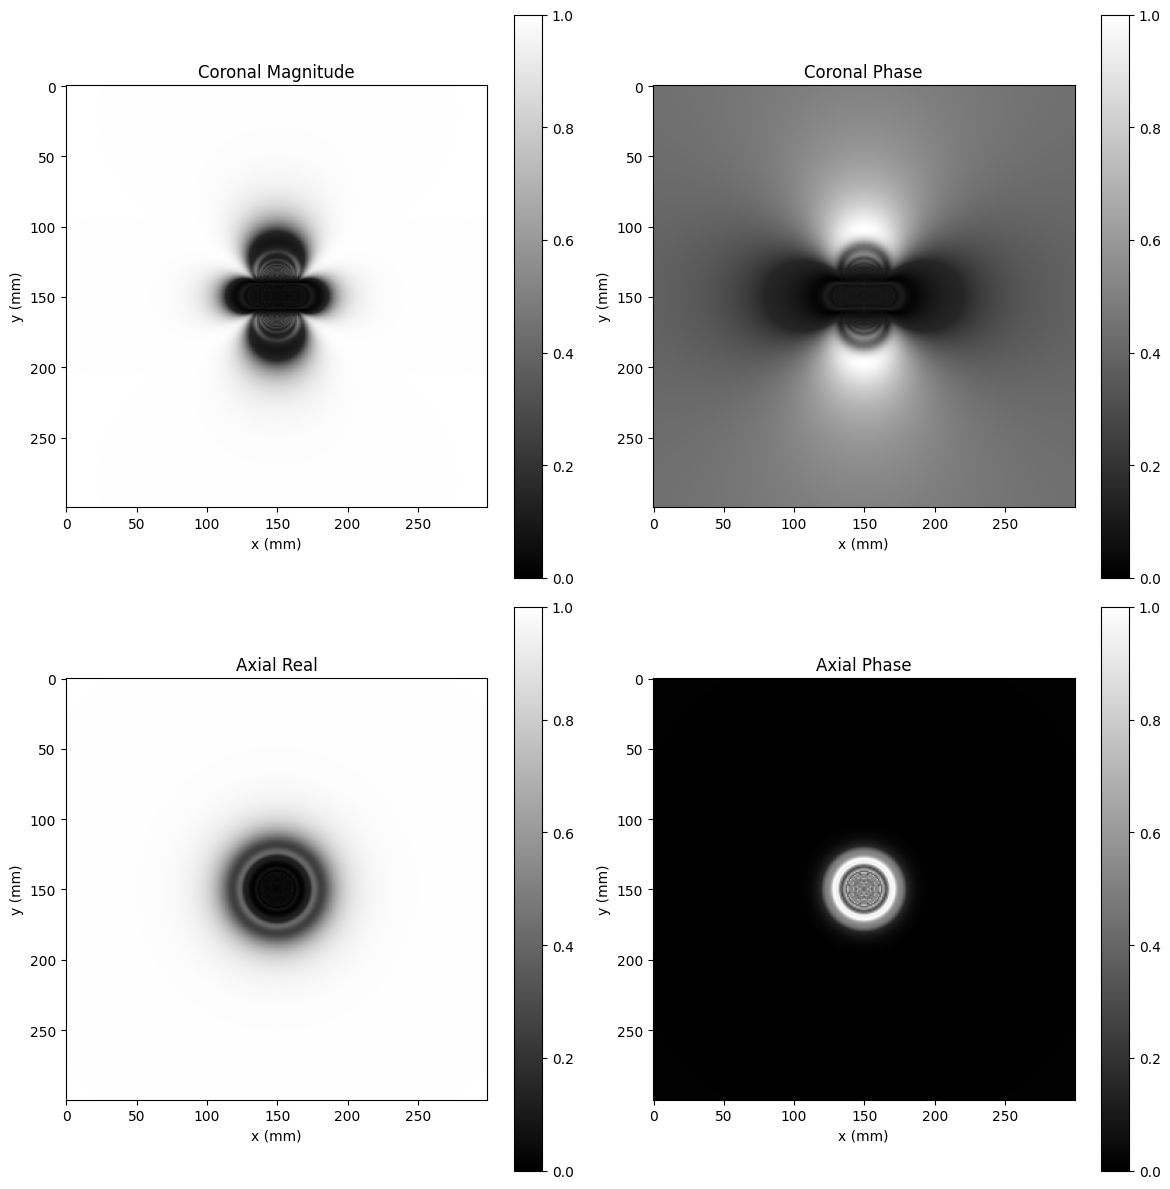

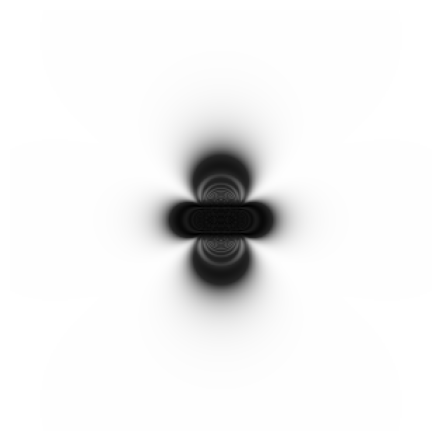

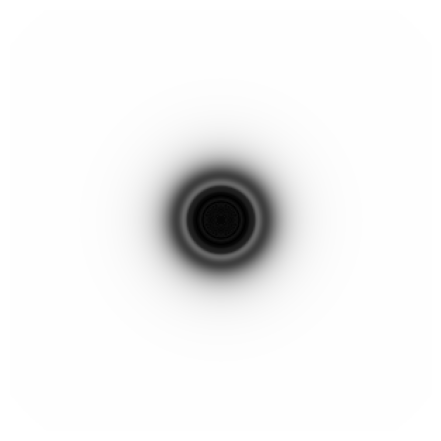

In [10]:
from matplotlib.colors import LinearSegmentedColormap
bSSFP_colors = [(0, (0, 0, 0)), (0.5, (0.15, 0.15, 0.15)), (1, (1, 1, 1))]
bSSFP_colors = LinearSegmentedColormap.from_list("", bSSFP_colors, N=65535)

coronal_phase_lut = bSSFP_colors(coronal_phase)
coronal_magnitude_lut = bSSFP_colors(coronal_magnitude)
axial_phase_lut = bSSFP_colors(axial_phase)
axial_magnitude_lut = bSSFP_colors(axial_magnitude)

group_plot(coronal_magnitude_lut, coronal_phase_lut, axial_magnitude_lut, axial_phase_lut)
quick_plot(coronal_magnitude_lut, cmap="gray", colorbar=False, axis=False)
quick_plot(axial_magnitude_lut, cmap="gray", colorbar=False, axis=False)

## OpenCV
OpenCV is used for saving images, augmentation and superimposing.

### Converting data to OpenCV
OpenCV is restricted to mostly 8-bit data. Or 16-bit is hard to work with so this project is currently limited to 8-bit.
Not yet sure if this is an issue or not. There is some noticeable data loss, but might not matter.

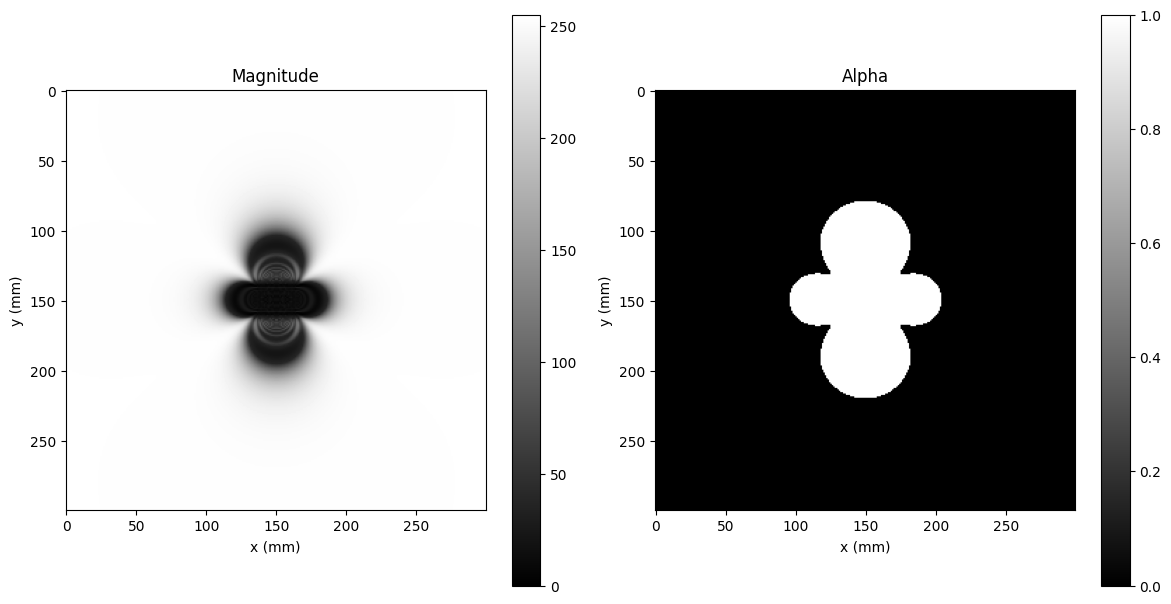

True

In [11]:
import cv2
MASK_SIGNAL_THRESHOLD = 0.9

def opencv_convert_16bit(magnitude):
    magnitude_16bit = (magnitude * 65535).astype(np.uint16)
    magnitude_16bit_gray = cv2.cvtColor(magnitude_16bit, cv2.COLOR_BGR2GRAY)
    binary = np.where(magnitude[:,:,0] > MASK_SIGNAL_THRESHOLD, 0, 1)
    return magnitude_16bit, magnitude_16bit_gray, binary

def opencv_convert_8bit(magnitude):
    magnitude_8bit = (magnitude * 255).astype(np.uint8)
    magnitude_8bit = cv2.cvtColor(magnitude_8bit, cv2.COLOR_BGR2GRAY)
    magnitude_color_8bit = cv2.cvtColor(magnitude_8bit, cv2.COLOR_GRAY2RGB)
    magnitude_alpha_8bit = (255 - magnitude_8bit).round().astype(np.uint8)
    # pre-multiplied alpha
    magnitude_premult = cv2.cvtColor(cv2.merge((magnitude_color_8bit, magnitude_alpha_8bit)), cv2.COLOR_RGBA2mRGBA)
    return magnitude_8bit, magnitude_premult
magnitude_8bit_gray, magnitude_premultiplied = opencv_convert_8bit(coronal_magnitude_lut)

# Get binary mask
_, _, binary_mask = opencv_convert_16bit(coronal_magnitude_lut)
group_plot(magnitude_8bit_gray, binary_mask, None, None, title1="Magnitude", title2="Alpha")
cv2.imwrite("test-images/magnitude_gray.png", magnitude_8bit_gray)
cv2.imwrite("test-images/magnitude_binary.png", binary_mask*255)

### Example superimposing
- resize artifact uniformly
- create white image with the same dimensions as background image
- place artifact on the white image at specified location
- element-wise multiply background with the white image with marker

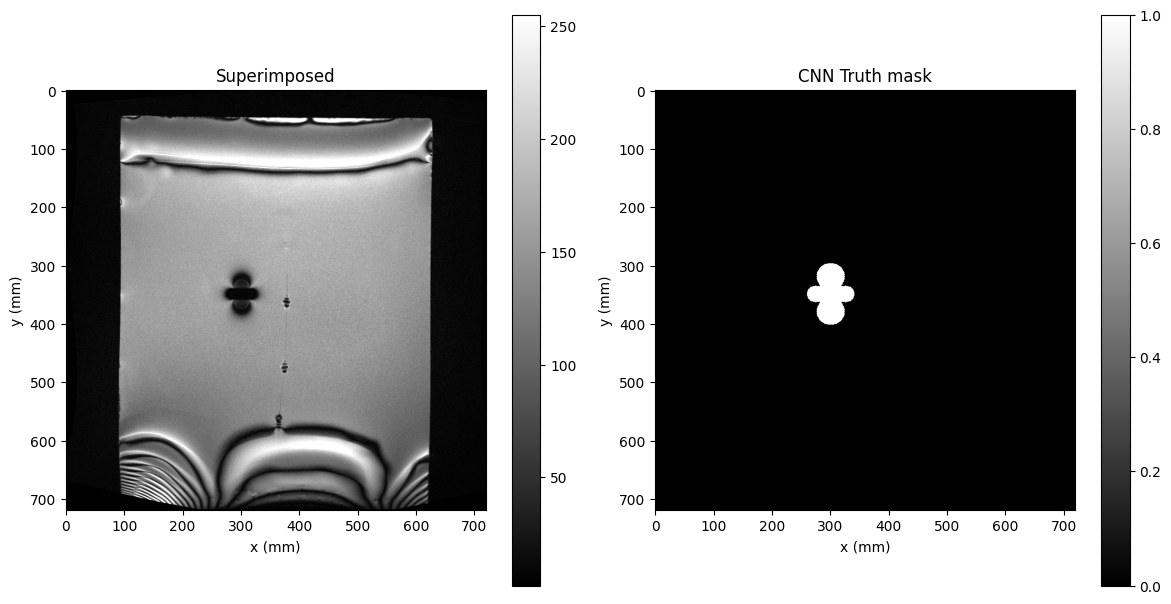

True

In [12]:
def superimpose_image(background, foreground, scale_px, position, binary=False):
    """
    Position is with relation to the center of the foreground image.
    scaling is done assuming artifact is generated on 300px image, and artifact width on that image is approx 80px.
    """
    # Foreground
    x, y = position
    if binary:
        foreground = foreground.astype(np.uint8)
    else:
        foreground = (foreground/255).astype(float)
    foreground = cv2.resize(foreground, (int(scale_px*3.75), int(scale_px*3.75)))
    height, width = foreground.shape
    
    # Background
    if isinstance(background, str):
        background = cv2.imread(background, cv2.IMREAD_GRAYSCALE)
    background = background.astype(np.uint8)
    
    # Foreground replacement
    if binary:
        background_white = np.zeros(background.shape, dtype=foreground.dtype)
    else:
        background_white = np.ones(background.shape, dtype=foreground.dtype)
    
    # Calculate replacement area
    top_left_x = x - width // 2
    top_left_y = y - width // 2
    start_x = max(top_left_x, 0)
    start_y = max(top_left_y, 0)
    end_x = min(top_left_x + width, background.shape[1])
    end_y = min(top_left_y + height, background.shape[0])
    
    # Handle if the position is partly outside the background
    foreground_cropped = foreground[max(0, -top_left_y):max(0, -top_left_y) + end_y - start_y,
                                    max(0, -top_left_x):max(0, -top_left_x) + end_x - start_x]
    
    # Replace and bit-wise multiply to overwrite
    background_white[start_y:end_y, start_x:end_x] = foreground_cropped
    if binary:
        return background_white
    background = np.multiply(background, background_white)
    return background.astype(np.uint8)

superimposed_example = superimpose_image("test-images/00004.jpg", magnitude_8bit_gray, scale_px=60, position=(300, 350))
superimposed_mask = superimpose_image("test-images/00004.jpg", binary_mask, scale_px=60, position=(300, 350), binary=True)

group_plot(superimposed_example.astype(np.uint8), superimposed_mask, None, None, title1="Superimposed", title2="CNN Truth mask")
cv2.imwrite("test-images/superimposed_example.png", superimposed_example.astype(np.uint8))

# Data Augmentation
- Contrast
- Size variance
- Noise

## Weaken contrast
Only contrast reduction currently.

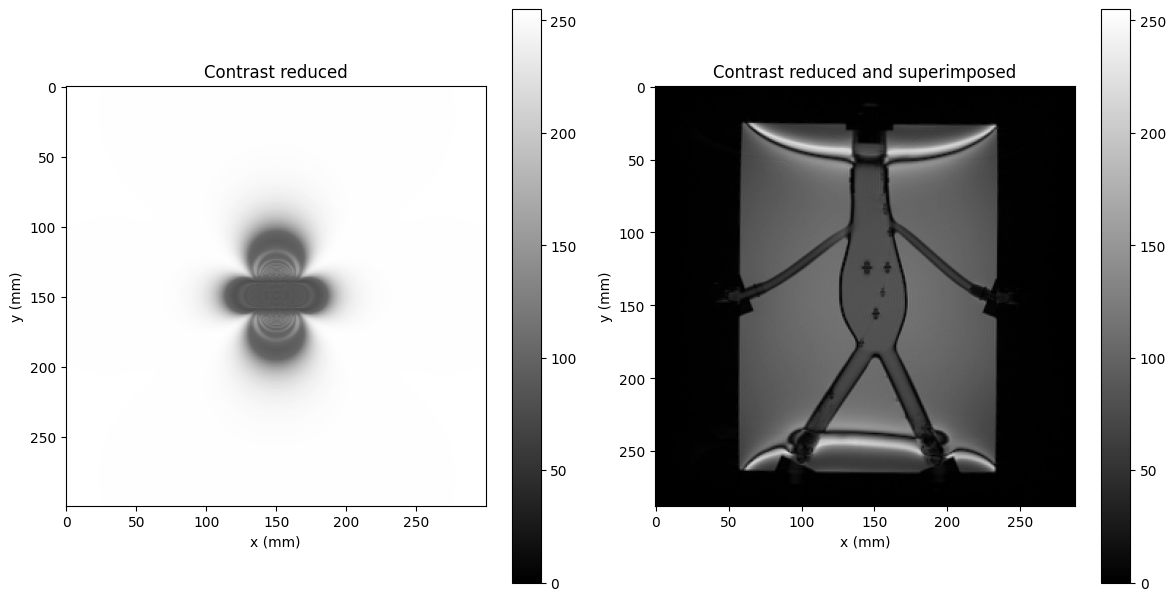

In [13]:
def adjust_contrast(image, scale):
        white_image = np.ones(image.shape, dtype=image.dtype) * 255
        adjusted_image = cv2.addWeighted(image, 0+scale, white_image, 1-scale, 0)
        return adjusted_image

reduced_contrast = adjust_contrast(magnitude_8bit_gray, 0.7)
superimposed_example = superimpose_image("test-images/00026.jpg", foreground=reduced_contrast, scale_px=7, position=(145, 125))
group_plot(reduced_contrast, superimposed_example, None, None,
           title1="Contrast reduced", title2="Contrast reduced and superimposed", clim=(0, 255))


In that particular image above, there are not that many pixels to work with, the width of artifact is approx 10 pixels.

## Noise
Noise is skipped right now, the resolution is too low for any noise.

# Segmentation dataset generation
This section will generate segmentation dataset for unet-nested (UNet++).
If segmentation is not sufficient, landmark (object detection) method such as gaussian kernel will be used instead.

## Settings
All dataset images will be converted to 512px square.
Artifacts were measured from real MRI images, scaled to 512px, 
the width ranges (pixels - from scaled 512px image): 7 - 13
The simulated artifact, on 300x300px image has a width of 80 pixels. 
The superimpose function calculated the size of the artifact accordingly.

In [14]:
SQUARE_IMAGE_SIZE = (512, 512)
ARTIFACT_SIZE_RANGE = [6, 12]  ## In pixels, width. @512 the artifact is 7 - 12 pixels
ARTIFACT_CONTRAST_RANGE = [0.5, 0.85]  # Just visually desired result
MINIMUM_DISTANCE_BETWEEN_MARKERS = 30  # pixels
MARKERS_ON_IMAGE = [3, 7]  # Range of markers, randomly selected

def get_uniform_contrast():
    return np.random.uniform(ARTIFACT_CONTRAST_RANGE[0], ARTIFACT_CONTRAST_RANGE[1])

def get_uniform_size():
    return int(np.random.uniform(ARTIFACT_SIZE_RANGE[0], ARTIFACT_SIZE_RANGE[1]))

def get_marker_amount():
    return int(np.random.uniform(MARKERS_ON_IMAGE[0], MARKERS_ON_IMAGE[1]))

def get_uniform_position(coordinates, previous_positions, minimum_distance):
    x1, y1, x2, y2 = coordinates
    while True:
        new_x = int(np.random.uniform(x1, x2))
        new_y = int(np.random.uniform(y1, y2))
        new_position = (new_x, new_y)
        if all(np.sqrt((new_x - x) ** 2 + (new_y - y) ** 2) >= minimum_distance for x, y in previous_positions):
            return new_position

## Each dataset background image is given a region of interest, where markers can be placed

Just to avoid placing markers in places where they should not be usually.
Read MRI images dataset from: https://humanheart-project.creatis.insa-lyon.fr/database/#collection/637218c173e9f0047faa00fb/folder/63721d7073e9f0047faa052a


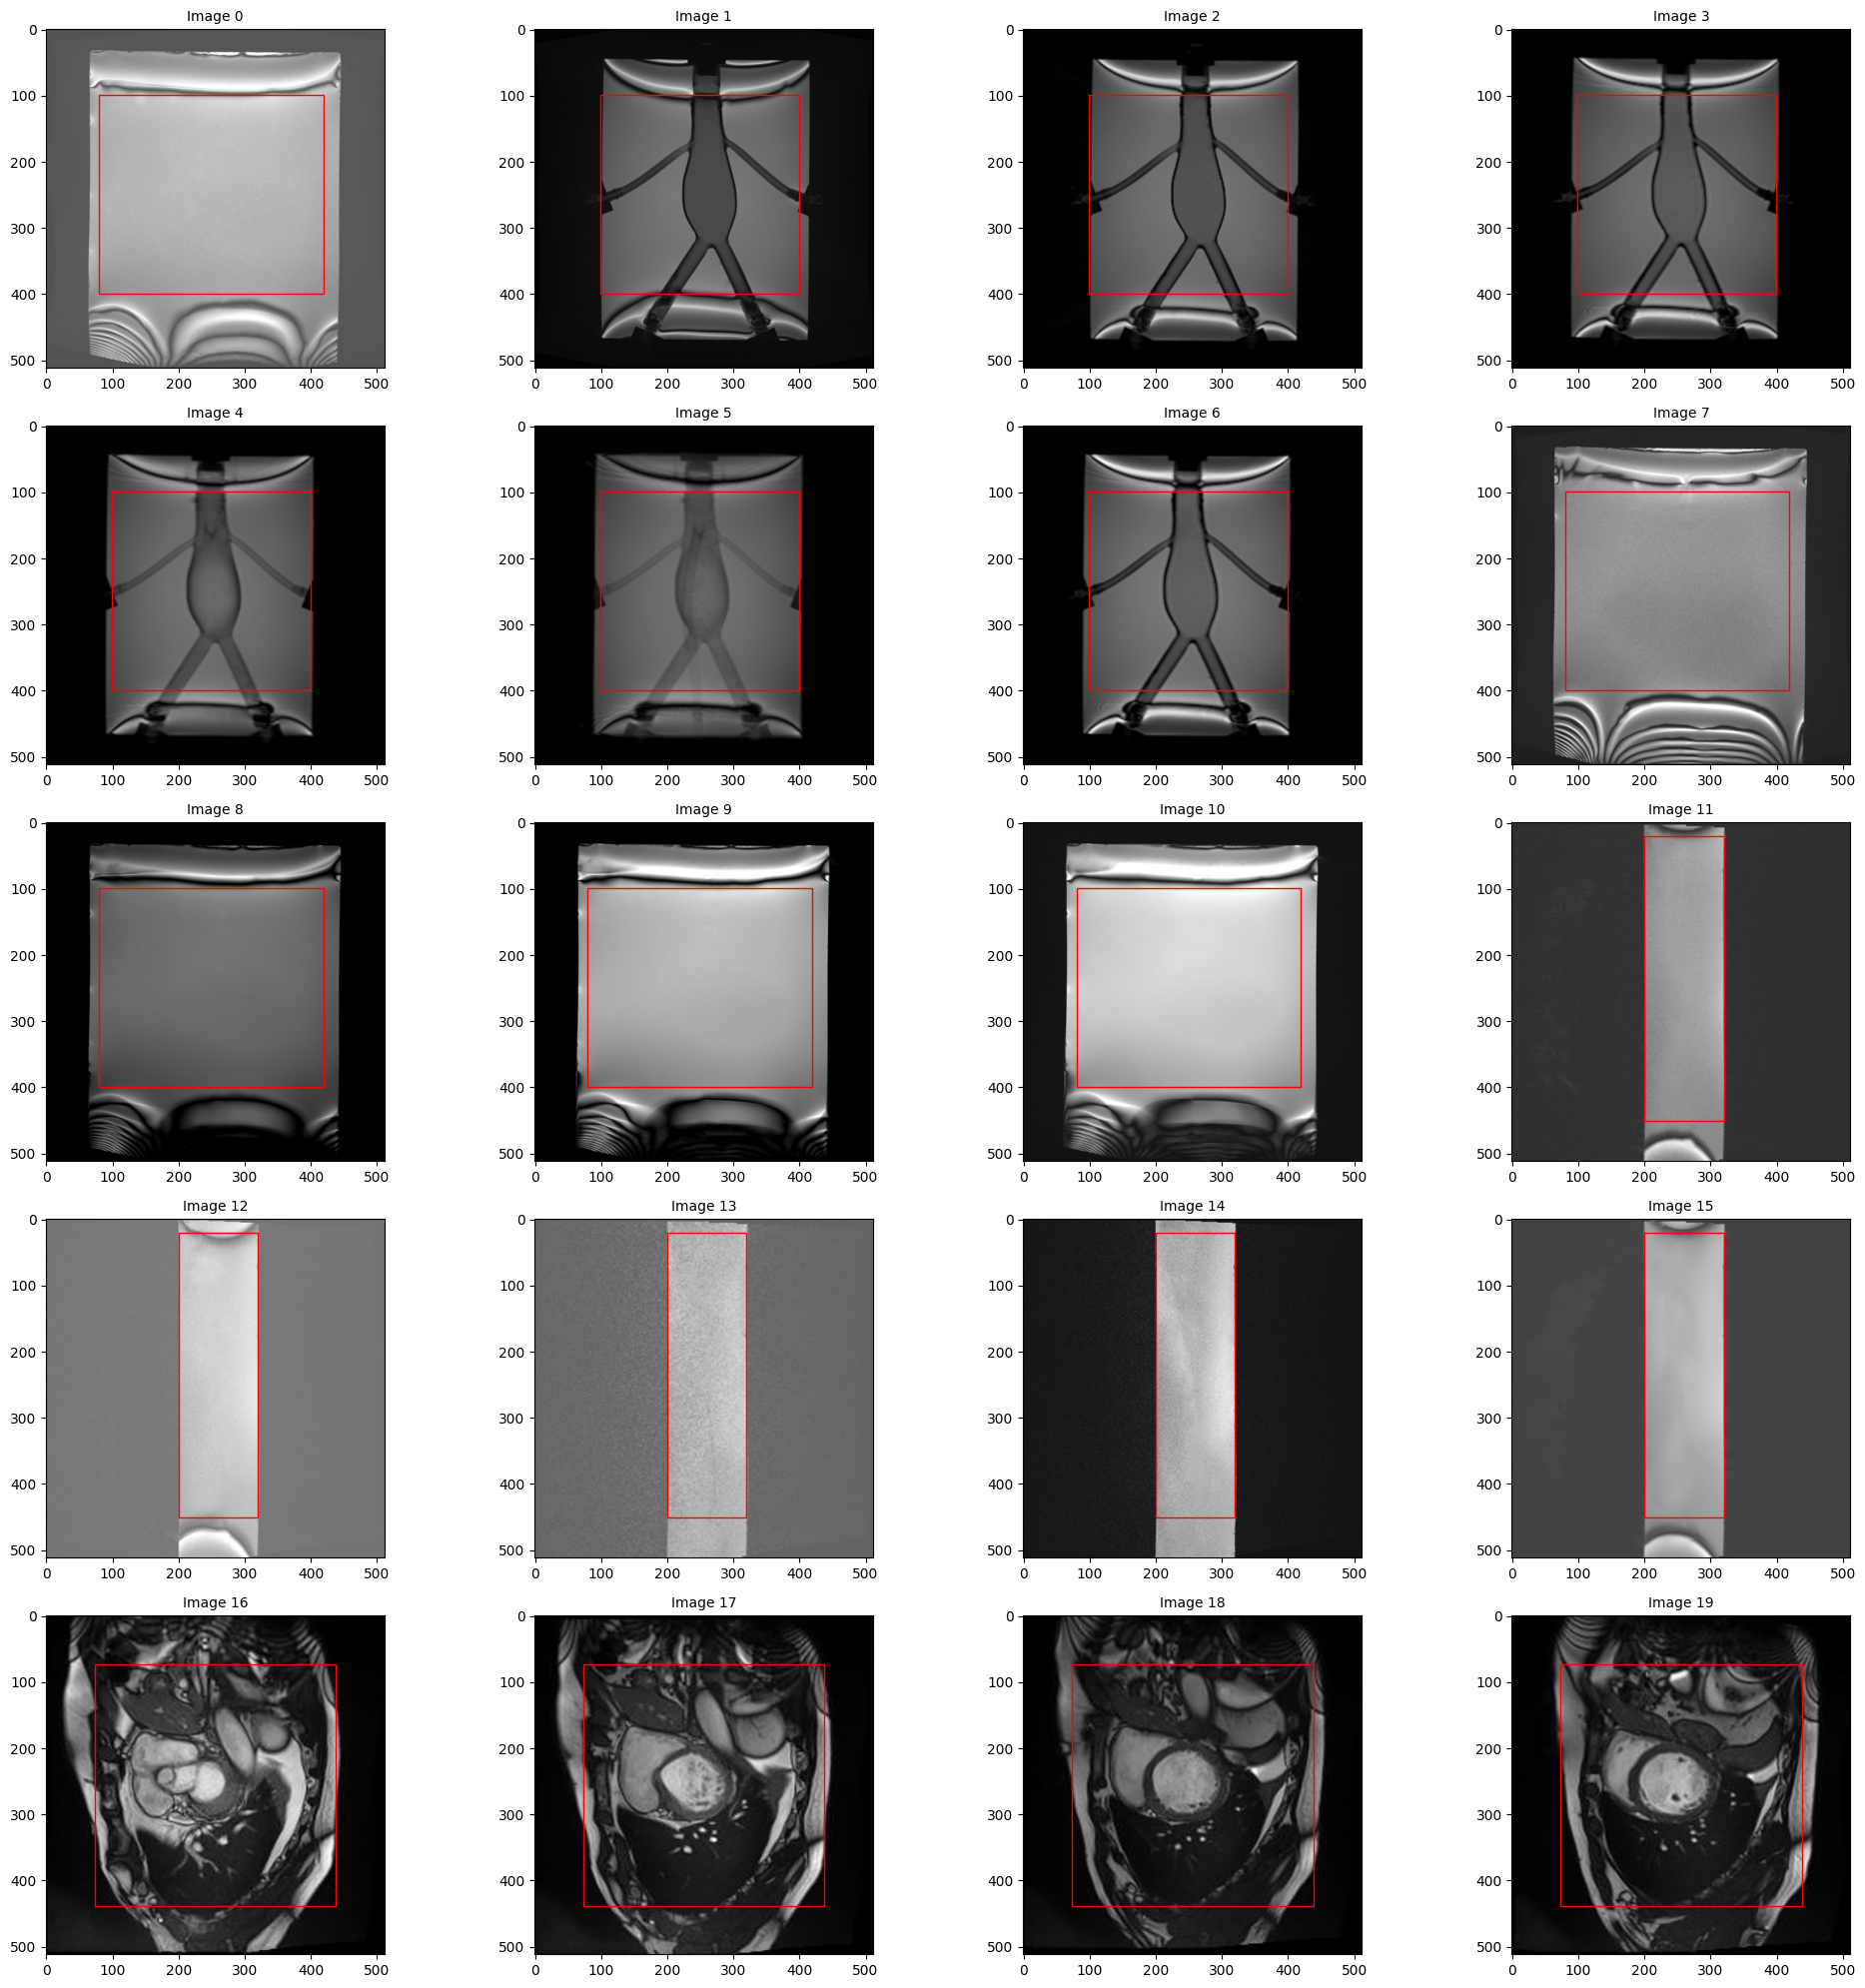

In [20]:
import os
from PIL import Image
import matplotlib.patches as patches

DATASET_BACKGROUND_IMAGES = "background_dataset"
# ROI = x1, y1, x2, y2
multiplier = 512/350

# These numbers are for image size 350. Adjust multiplier accordingly for different size image.
ROI_WATER_LARGE = [55, 68, 287, 273]
ROI_WATER_THIN = [137, 14, 219, 308]
ROI_PHANTOM = [68, 68, 273, 273]
HEART_REAL_1 = [50, 50, 300, 300]
HEART_REAL_2 = [100, 50, 300, 300]

ROI_WATER_LARGE = [int(number * multiplier) for number in ROI_WATER_LARGE]
ROI_WATER_THIN = [int(number * multiplier) for number in ROI_WATER_THIN]
ROI_PHANTOM = [int(number * multiplier) for number in ROI_PHANTOM]
HEART_REAL_1 = [int(number * multiplier) for number in HEART_REAL_1]
HEART_REAL_2 = [int(number * multiplier) for number in HEART_REAL_2]

ROI = [ROI_WATER_LARGE, ROI_PHANTOM,               # 0-1 
         ROI_PHANTOM, ROI_PHANTOM,                 # 2-3
         ROI_PHANTOM, ROI_PHANTOM,                 # 4-5
         ROI_PHANTOM, ROI_WATER_LARGE,             # 6-7
         ROI_WATER_LARGE, ROI_WATER_LARGE,         # 8-9
         ROI_WATER_LARGE, ROI_WATER_THIN,          # 10-11
         ROI_WATER_THIN, ROI_WATER_THIN,           # 12-13
         ROI_WATER_THIN, ROI_WATER_THIN,           # 14-15
         HEART_REAL_1, HEART_REAL_1, HEART_REAL_1, # 16-17-18
         HEART_REAL_1, HEART_REAL_1]               # 19-20   

background_dataset = sorted(os.listdir(DATASET_BACKGROUND_IMAGES), key=lambda x: int(x.split('.')[0]))
fig, axs = plt.subplots(*(5, 4), figsize=(20, 20))
for ID, image_file in enumerate(background_dataset):
    img_path = os.path.join(DATASET_BACKGROUND_IMAGES, image_file)
    row = ID // 4
    col = ID % 4
    with Image.open(img_path) as img:
        img = img.resize(SQUARE_IMAGE_SIZE)
        axs[row, col].imshow(img)
        rect = patches.Rectangle((ROI[ID][0], ROI[ID][1]), ROI[ID][2] - ROI[ID][0], ROI[ID][3] - ROI[ID][1], 
                                 linewidth=1, edgecolor='r', facecolor='none')
        axs[row, col].add_patch(rect)
        axs[row, col].set_title(f"Image {ID}", fontsize=10)
plt.tight_layout()
plt.show()

## Generating a dataset
- working per-image basis, each image will be given multiple variations.
- add artifact with randomized parameters
- create mask with same variables
- finally merge all individual masks into a single mask

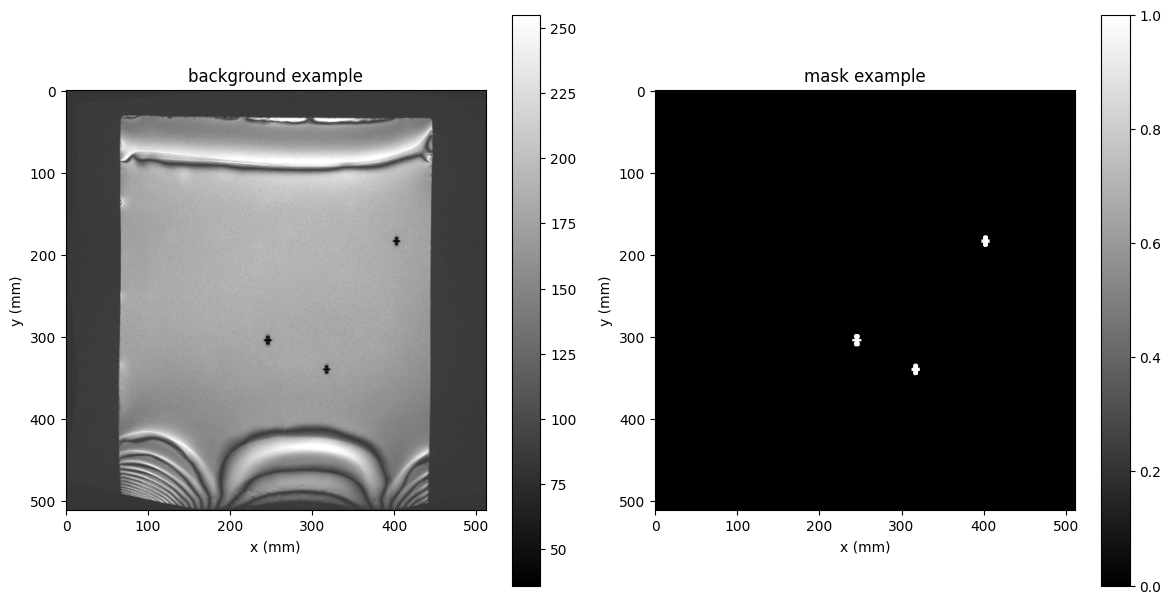

In [21]:
DATASET_DESTINATION_IMAGES = "generated_dataset/images"
DATASET_DESTINATION_MASKS = "generated_dataset/masks"
IMAGES_PER_BACKGROUND = 35
import shutil

def recreate_dir(path):
    if os.path.exists(path):
        shutil.rmtree(path)
    os.makedirs(path)

recreate_dir(DATASET_DESTINATION_IMAGES)
recreate_dir(DATASET_DESTINATION_MASKS)

image_id = 0
background_dataset = sorted(os.listdir(DATASET_BACKGROUND_IMAGES), key=lambda x: int(x.split('.')[0]))
for ID, image_file in enumerate(background_dataset):
    img_path = os.path.join(DATASET_BACKGROUND_IMAGES, image_file)
    background_image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    background_image = cv2.resize(background_image, SQUARE_IMAGE_SIZE)
    MARKER_POSITION_LIMITS = ROI[ID][0], ROI[ID][1], ROI[ID][2], ROI[ID][3]
    for i in range(IMAGES_PER_BACKGROUND):
        MARKER_MASKS = None
        filename = "susceptibility-generated" # secrets.token_hex(16)
        BACKGROUND_SUPERIMPOSED = background_image
        previous_marker_positions = []
        for j in range(get_marker_amount()):
            procedural_marker = adjust_contrast(magnitude_8bit_gray, get_uniform_contrast())
            marker_size = get_uniform_size()
            marker_position = get_uniform_position(MARKER_POSITION_LIMITS, 
                                                   previous_marker_positions, 
                                                   minimum_distance=MINIMUM_DISTANCE_BETWEEN_MARKERS)
            previous_marker_positions.append(marker_position)
            BACKGROUND_SUPERIMPOSED = superimpose_image(BACKGROUND_SUPERIMPOSED, 
                                                    foreground=procedural_marker, 
                                                    scale_px=marker_size, 
                                                    position=marker_position)
            superimposed_marker_mask = superimpose_image(BACKGROUND_SUPERIMPOSED, 
                                                    foreground=binary_mask, 
                                                    scale_px=marker_size, 
                                                    position=marker_position,
                                                    binary=True)
            if MARKER_MASKS is None:
                MARKER_MASKS = superimposed_marker_mask
            else:
                MARKER_MASKS = np.bitwise_or(MARKER_MASKS, superimposed_marker_mask)
        
        cv2.imwrite(f"{DATASET_DESTINATION_IMAGES}/{filename}_{image_id:03}_0000.png", BACKGROUND_SUPERIMPOSED)
        cv2.imwrite(f"{DATASET_DESTINATION_MASKS}/{filename}_{image_id:03}.png", MARKER_MASKS.astype(np.uint8))
        image_id += 1
        if ID == 0 and i == 0:
            group_plot(BACKGROUND_SUPERIMPOSED.astype(np.uint8), MARKER_MASKS, None, None,
                       title1="background example", title2="mask example")
            
        

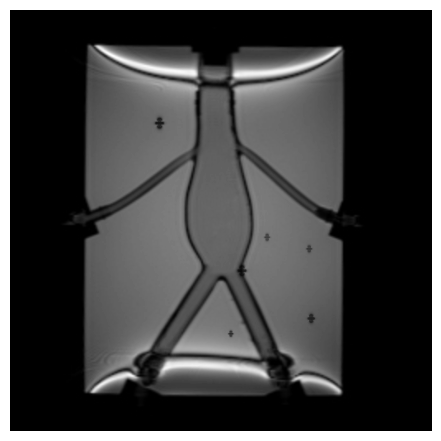

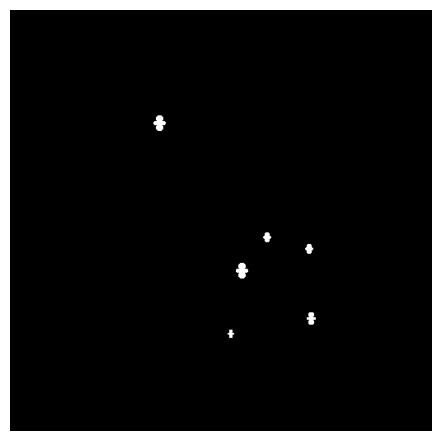

In [22]:
# Just show some specific files for conference
generated_images = "generated_dataset/images"
generated_masks = "generated_dataset/masks"
filename = "_115"
matching_image = [file for file in os.listdir(generated_images) if filename in file][0]
matching_mask = [file for file in os.listdir(generated_masks) if filename in file][0]
matching_image = plt.imread(os.path.join(generated_images, matching_image))
matching_mask = plt.imread(os.path.join(generated_masks, matching_mask))

quick_plot(matching_image, cmap="gray", colorbar=False, axis=False)
quick_plot(matching_mask, cmap="gray", colorbar=False, axis=False)

## Plot the results from nnUNet ~50 epoch

In [23]:
results_nnunet = "generated_dataset/RESULTS/OUTPUT"
input_nnunet = "generated_dataset/RESULTS/INPUT"

for filename in os.listdir(results_nnunet):
    img1 = Image.open(os.path.join(results_nnunet, filename))
    img2 = Image.open(os.path.join(input_nnunet, filename))
    img1 = np.array(img1).astype(np.uint8)
    img2 = np.array(img2).astype(np.uint8)
    group_plot(img1, img2, None, None, title1="nn U-Net", title2=f"Ground Truth / Image\n{filename}")

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'generated_dataset/RESULTS/OUTPUT'